In [ ]:
from datasets import load_dataset
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer
from torchvision import transforms
from evaluate import load as load_metric
from transformers import logging
logging.set_verbosity_info()
print("Libraries imported successfully.")
# 1. Load dataset (Food-101 for demo; replace with your custom dataset if needed)
dataset = load_dataset("indian_food_images", data_dir="/indian_food_images")
print("Dataset loaded successfully.")
# Update label mapping
labels = dataset["train"].features["label"].names
num_labels = len(labels)

base_model = "google/mobilenet_v2_1.0_224"  # previously trained model
model = AutoModelForImageClassification.from_pretrained(
    base_model,
    num_labels=num_labels,
    ignore_mismatched_sizes=True # allows head to be resized
    )
processor = AutoImageProcessor.from_pretrained(base_model)
print("Model and processor loaded successfully.", num_labels)

model.config.id2label = {i: label for i, label in enumerate(labels)}
model.config.label2id = {label: i for i, label in enumerate(labels)}

print("Label mapping updated successfully.")

Libraries imported successfully.


EmptyDatasetError: The directory at /Users/sumithb/Projects/NutriSnap/indian_food_images/indian_food_images doesn't contain any data files

In [13]:
from torchvision import transforms
from PIL import Image
import torch

# Define transforms (no ToTensor yet)
normalize = transforms.Normalize(mean=processor.image_mean, std=processor.image_std)

base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
])

to_tensor = transforms.Compose([
    transforms.ToTensor(),
    normalize,
])

# ✅ Safe conversion to PIL
def safe_to_pil(img):
    if isinstance(img, Image.Image):
        return img.convert("RGB")
    elif hasattr(img, "convert"):
        return img.convert("RGB")
    else:
        return Image.open(img).convert("RGB")

# ✅ Custom collate_fn — all logic lives here now
def collate_fn(batch):
    images = [safe_to_pil(b["image"]) for b in batch]
    images = [base_transform(img) for img in images]
    pixel_values = torch.stack([to_tensor(img) for img in images])
    labels = torch.tensor([b["label"] for b in batch], dtype=torch.long)
    return {"pixel_values": pixel_values, "labels": labels}

# ✅ No need for set_transform anymore
train_dataset = dataset["train"]
eval_dataset = dataset["test"]



In [14]:
from transformers import TrainingArguments, Trainer
import evaluate
import torch

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.argmax(torch.tensor(logits), dim=-1)
    return accuracy.compute(predictions=preds, references=labels)

training_args = TrainingArguments(
    output_dir="./mobilenetv2-indianfood",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    save_strategy="epoch",
    learning_rate=2e-4,     # lower LR since we’re fine-tuning
    weight_decay=0.01,
    remove_unused_columns=False,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=processor,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/var/folders/zh/63djkv3s28n02td1xqc3fn9h0000gn/T/ipykernel_3760/3451400844.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [15]:
trainer.train()


***** Running training *****
  Num examples = 5,328
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 835
  Number of trainable parameters = 2,249,492


Step,Training Loss
500,0.465600


Saving model checkpoint to ./mobilenetv2-indianfood/checkpoint-167
Configuration saved in ./mobilenetv2-indianfood/checkpoint-167/config.json
Model weights saved in ./mobilenetv2-indianfood/checkpoint-167/model.safetensors
Image processor saved in ./mobilenetv2-indianfood/checkpoint-167/preprocessor_config.json
/Users/sumithb/Projects/NutriSnap/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Saving model checkpoint to ./mobilenetv2-indianfood/checkpoint-334
Configuration saved in ./mobilenetv2-indianfood/checkpoint-334/config.json
Model weights saved in ./mobilenetv2-indianfood/checkpoint-334/model.safetensors
Image processor saved in ./mobilenetv2-indianfood/checkpoint-334/preprocessor_config.json
/Users/sumithb/Projects/NutriSnap/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_m

TrainOutput(global_step=835, training_loss=0.320908707487369, metrics={'train_runtime': 469.0968, 'train_samples_per_second': 56.79, 'train_steps_per_second': 1.78, 'total_flos': 5.412366723907584e+16, 'train_loss': 0.320908707487369, 'epoch': 5.0})

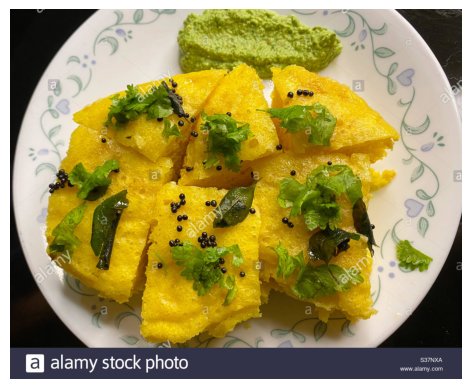

1. dhokla                    — 99.91%
2. kadai_paneer              — 0.07%
3. butter_naan               — 0.01%


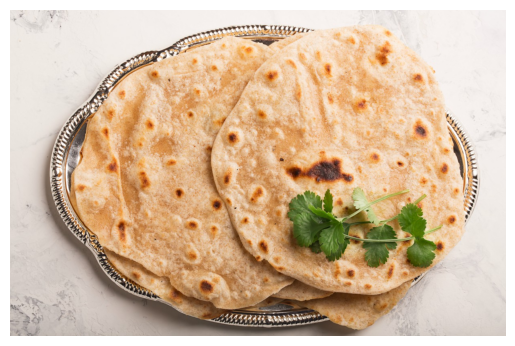

1. chapati                   — 99.99%
2. butter_naan               — 0.00%
3. dal_makhani               — 0.00%


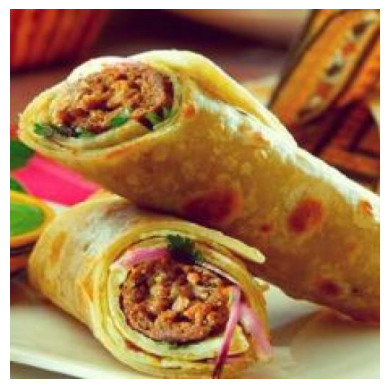

1. kaathi_rolls              — 99.39%
2. samosa                    — 0.59%
3. chapati                   — 0.02%


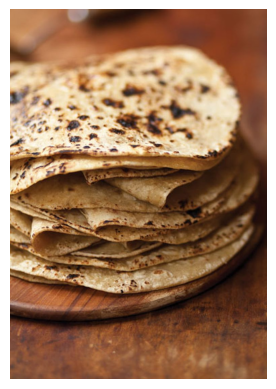

1. chapati                   — 74.89%
2. butter_naan               — 24.73%
3. dal_makhani               — 0.22%


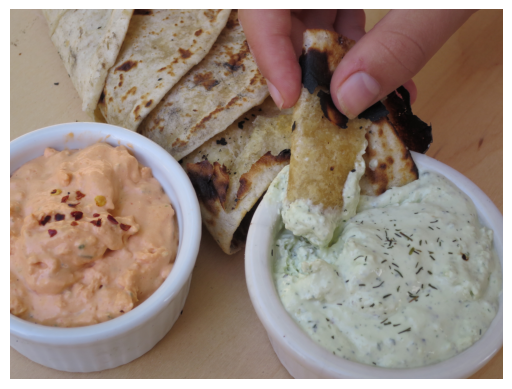

1. butter_naan               — 98.11%
2. chapati                   — 1.53%
3. kulfi                     — 0.13%


In [18]:
import torch
from PIL import Image
from torchvision import transforms
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 1️⃣ Load model and processor
model.eval()

# 2️⃣ Device setup
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

# 3️⃣ Define transform (same as validation)
normalize = transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,
])

# 4️⃣ Predict function
def predict(image, top_k=3):
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    inputs = test_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(inputs).logits
        probs = F.softmax(logits, dim=-1)
        top = torch.topk(probs, k=top_k)

    for i, (idx, score) in enumerate(zip(top.indices[0], top.values[0])):
        label = model.config.id2label[idx.item()]
        print(f"{i+1}. {label:<25} — {score.item()*100:.2f}%")

# 5️⃣ Test on a few sample images
test_images = dataset["test"].shuffle(seed=42).select(range(5))["image"]

for path in test_images:
    predict(path)


In [19]:
trainer.save_model("./mobilenetv2-indianfood")
processor.save_pretrained("./mobilenetv2-indianfood")

Saving model checkpoint to ./mobilenetv2-indianfood
Configuration saved in ./mobilenetv2-indianfood/config.json
Model weights saved in ./mobilenetv2-indianfood/model.safetensors
Image processor saved in ./mobilenetv2-indianfood/preprocessor_config.json
Image processor saved in ./mobilenetv2-indianfood/preprocessor_config.json


['./mobilenetv2-indianfood/preprocessor_config.json']